<h1> Song Lyric Analysis </h1>
    <br>
    By: Noah Burkhardt, Courtland Climer, Ares Shackleford, and Ryan Sutton

In [48]:
!pip install spotipy
!pip install billboard.py
!pip install lyricsgenius
!pip install nltk
!pip install matplotlib
!pip install seaborn

In [49]:
import pandas as pd
import numpy as np
import billboard as bb
import lyricsgenius
import seaborn as sns
import nltk
from sklearn.feature_extraction.text import CountVectorizer
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from sklearn.feature_extraction.text import TfidfVectorizer

In [50]:
genius = lyricsgenius.Genius("JxIIf2vA02Oopvz2JRUbC6iysXRZnNEHN0j84a16uLsB8niafpsNZPR1SvcSxu8r")
genius.verbose = False # Turn off status messages
genius.remove_section_headers = True # Remove section headers (e.g. [Chorus]) from lyrics when searching
genius.skip_non_songs = False # Include hits thought to be non-songs (e.g. track lists)
genius.excluded_terms = ["(Remix)", "(Live)"] # Exclude songs with these words in their title

The above cell sets up using the genius API to get lyrics for specific songs. One would need to replace "Api Key" with their own genius API key in order to use the API. If you want to know more about the genius api you can find information about it here: https://docs.genius.com/. If you want to know more about the lyricsgenius python library that wraps the genius API you can find more about it here: https://github.com/johnwmillr/LyricsGenius. We tried using many different lyrics sites/APIs to get the lyrics such as Musixmatch or azlyrics, but we ran into the problem that you needed a paid API key to get access to all of the lyrics or that the search function for songs did not work with the way Billboard formulated the Song artist and title.

In [51]:
def create_songs_df(chart_name):
    top100 = bb.ChartData(chart_name)
    songs = top100.entries
    dataframe = {"Rank": [], "Title": [], "Artist": []}
    for song in songs:
        dataframe["Title"].append(song.title)
        dataframe["Artist"].append(song.artist)
        dataframe["Rank"].append(song.rank)
    df = pd.DataFrame(dataframe)
    return df

The above cell allows for creation of dataframes to store different charts from the billboard website. We used a billboard python package that you can find more information about here https://github.com/guoguo12/billboard-charts. This method creates a dataframe for a specific chart with columns for song title, song artist, and the rank of the song on the chart and then returns the dataframe.

In [52]:
top100 = create_songs_df("hot-100")
country = create_songs_df("country-songs")
rock = create_songs_df("rock-songs")
pop = create_songs_df("pop-songs")
rap = create_songs_df('rap-song')

Here we load in five different billboard top100 charts that we will use later to perform our analysis. If you want to explore Billboard's website you can view it here: https://www.billboard.com/ and you can find more information about how the charts are actually compiled here: https://www.billboard.com/p/billboard-charts-legend.

In [53]:
def try_load_lyrics(title,artist):
    try:
        return genius.search_song(title, artist).lyrics
    except:
        return "Failed to Find Lyrics"

In [54]:
def populate_chart_with_lyrics(chart):
    chart["lyrics"] = chart.apply(lambda x: try_load_lyrics(x["Title"],x["Artist"]), axis = 1)
    return chart

The above methods are used to add a column to a dataframe for the lyrics of each song using the genius API.

In [55]:
top100 = populate_chart_with_lyrics(top100)
display(top100)
len(top100[top100['lyrics'] == 'Failed to Find Lyrics'])

,Rank,Title,Artist,lyrics
0,1,Heartless,The Weeknd,"Young Metro, young Metro, young Metro (Sheesh)..."
1,2,Circles,Post Malone,"Oh, oh, oh\nOh, oh, oh\nOh, oh, oh, oh, oh\n..."
2,3,All I Want For Christmas Is You,Mariah Carey,I don't want a lot for Christmas\nThere is jus...
3,4,Someone You Loved,Lewis Capaldi,"I'm going under, and this time, I fear there's..."
4,5,Memories,Maroon 5,Here's to the ones that we got\nCheers to the ...
5,6,Good As Hell,Lizzo,"I do my hair toss, check my nails\nBaby, how y..."
6,7,Roxanne,Arizona Zervas,All for the 'Gram\nBitches love the 'Gram\nOh ...
7,8,Rockin' Around The Christmas Tree,Brenda Lee,Rockin' around the Christmas tree\nAt the Chri...
8,9,Lose You To Love Me,Selena Gomez,You promised the world and I fell for it\nI pu...
9,10,"10,000 Hours",Dan + Shay & Justin Bieber,"Do you love the rain, does it make you dance\n..."


0

In [56]:
client_credentials_manager = SpotifyClientCredentials(client_id = "ee9a1f8e2f634959967d52ed9fad54de", client_secret = "934a6bbc90e74664b502638f6f5fc92b")
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

We use a python wrapper for the Spotify API called spotipy. The documentation for spotipy can be found here: https://spotipy.readthedocs.io/en/latest/#non-authorized-requests. The documentation for the Spotify API as a whole can be found here: https://developer.spotify.com/documentation/web-api/

In [57]:
def get_spotify_popularity(title):
    title = title.replace("$","s")
    answer = sp.search(title, type="track", limit = 1)
    track = sp.track(answer["tracks"]["items"][0]["id"])
    return track["popularity"]

The above method gets the Spotify popularity associated with a specific song. The popularity metric on Spotify is a number between 0 and 100 based on how many plays the track has and how recent those plays are. The algorithm is not publically available, but if you want to look at the API documentation it is here: https://developer.spotify.com/documentation/web-api/reference/tracks/get-track/.

In [58]:
def populate_chart_with_spotify_popularity(chart):
    chart["spotify_popularity"] = chart.apply(lambda x: get_spotify_popularity(x["Title"]), axis = 1)
    return chart

This method adds a column to an existing dataframe of a music chart with the Spotify popularity of each song.

In [59]:
top100 = populate_chart_with_spotify_popularity(top100)
display(top100)

,Rank,Title,Artist,lyrics,spotify_popularity
0,1,Heartless,The Weeknd,"Young Metro, young Metro, young Metro (Sheesh)...",94
1,2,Circles,Post Malone,"Oh, oh, oh\nOh, oh, oh\nOh, oh, oh, oh, oh\n...",99
2,3,All I Want For Christmas Is You,Mariah Carey,I don't want a lot for Christmas\nThere is jus...,95
3,4,Someone You Loved,Lewis Capaldi,"I'm going under, and this time, I fear there's...",96
4,5,Memories,Maroon 5,Here's to the ones that we got\nCheers to the ...,100
5,6,Good As Hell,Lizzo,"I do my hair toss, check my nails\nBaby, how y...",86
6,7,Roxanne,Arizona Zervas,All for the 'Gram\nBitches love the 'Gram\nOh ...,98
7,8,Rockin' Around The Christmas Tree,Brenda Lee,Rockin' around the Christmas tree\nAt the Chri...,90
8,9,Lose You To Love Me,Selena Gomez,You promised the world and I fell for it\nI pu...,98
9,10,"10,000 Hours",Dan + Shay & Justin Bieber,"Do you love the rain, does it make you dance\n...",94


In [60]:
def create_term_doc_matrix(chart):
    lyrics = chart["lyrics"].to_list()
    vec = CountVectorizer()
    X = vec.fit_transform(lyrics)
    termdocmatrix = pd.DataFrame(X.toarray(), columns=vec.get_feature_names(), index=chart.Title)
    return termdocmatrix

top100 = top100[top100.lyrics != "Failed to Find Lyrics"]
create_term_doc_matrix(top100)

,000,02,10,100,101,10k,11,12,12am,14,...,yvncc,zaar,zella,zervas,zhu,zombie,zoom,zumban,él,íta
Title,,,,,,,,,,,,,,,,,,,,,
Heartless,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
Circles,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
All I Want For Christmas Is You,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Someone You Loved,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Memories,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Good As Hell,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Roxanne,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Rockin' Around The Christmas Tree,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Lose You To Love Me,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


This method creates a term-document matrix, which is a matrix that has every word in every song in the dataframe as a column and then the count of how many times each word appeared in a specific songas the value for each row, which in our case is a song. If you want to read further about term-document matrices here is a short blog post that explains the idea https://www.darrinbishop.com/blog/2017/10/text-analytics-document-term-matrix/.

In [61]:
def create_tfidf(chart):
    lyrics = chart["lyrics"].to_list()
    vectorizer = TfidfVectorizer()
    doc_vec = vectorizer.fit_transform(lyrics)
    tfidf = pd.DataFrame(doc_vec.toarray().transpose(), index=vectorizer.get_feature_names())
    tfidf.columns = chart["Title"]
    return tfidf

tfidf = create_tfidf(top100)
tfidf

Title,Heartless,Circles,All I Want For Christmas Is You,Someone You Loved,Memories,Good As Hell,Roxanne,Rockin' Around The Christmas Tree,Lose You To Love Me,"10,000 Hours",...,Follow God,Cuban Links,F.N,Candy,Tusa,Make No Sense,Jerry Sprunger,RITMO (Bad Boys For Life),Into The Unknown,La Cancion
000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008207,0.000000,0.000000
02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008207,0.000000,0.000000
10,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.248512,0.000000,0.000000
100,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
101,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
10k,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
11,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007531,0.000000,0.000000
12,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007531,0.000000,0.000000
12am,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008207,0.000000,0.000000
14,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008207,0.000000,0.000000


This method creates a term frequency-inverse document frequency (tf-idf) matrix. This is done by multiplying the term frequency score for each value by the inverse document frequency score of each value. The term frquency is calculated for each word in each song by counting the number of times the word appears in the song and dividing it by the total number of words in the song. The idf score is the inverse document frequency of a word, which is defined as the log(# of documents or in this case songs/ # of documents with the word in them). These matrices are used to determine the importance of a word to a song based off how often it is used in the song itself and in the other songs in the dataframe. A word is more important if it is only used by a single song in the dataframe. If you want to read more about tf-idf matrices here is a good resource: http://www.tfidf.com/.

In [62]:
def average_cosine_similarity(tfidf):
    similarity = 0
    count = 0
    for index in range(tfidf.shape[1]):
        col = tfidf.iloc[: , index]
        for ind2 in range(index + 1, tfidf.shape[1]):
            col2 = tfidf.iloc[: , ind2]
            similarity = similarity + np.dot(col.values,col2.values)/(np.linalg.norm(col.values)*np.linalg.norm(col2.values))
            count = count + 1
    return similarity/count

This method calculates the average pairwise cosine similarity for each song in the chart. Cosine similarity is a measure of the similarity between two different songs x and y. It is calculated by similarity(x,y) = $\frac{x^Ty}{|x| * |y|}$. This gives a value between 0 and 1, with 0 meaning the vectors are not related at all and 1 meaning the vectors are the same. If you want to read more about cosine similarity you can look here: https://www.machinelearningplus.com/nlp/cosine-similarity/.

In [99]:
def top_pairwise_cosine_similarity(tfidf):
    similarity = 0
    songs = []
    for index in range(tfidf.shape[1]):
        col = tfidf.iloc[: , index]
        for ind2 in range(index + 1, tfidf.shape[1]):
            col2 = tfidf.iloc[: , ind2]
            temp = np.dot(col.values,col2.values)/(np.linalg.norm(col.values)*np.linalg.norm(col2.values))
            if temp > similarity:
                similarity = temp
                names = [col.name,col2.name]
    return similarity, names

This method calculates and returns the cosine similarity for the most similar pair of songs in the chart and the names of the two songs that were the most similar.

In [63]:
def percent_of_top_100(songs):
    count = 0
    len = songs.shape[0] #num of rows
    
    for index, row in songs.iterrows():
        if ((top100['Title'] == row['Title']) & (top100['Artist'] == row['Artist'])).any():
            count += 1
            
    return count / 100
            
display(percent_of_top_100(rock))
display(percent_of_top_100(pop))
display(percent_of_top_100(country))

0.0

0.27

0.12

In [64]:
def get_lyric_len(chart):
    return create_term_doc_matrix(chart).sum(axis = 1, skipna = True)

display(get_lyric_len(top100))

Title
Heartless                           347
Circles                             300
All I Want For Christmas Is You     348
Someone You Loved                   303
Memories                            436
                                   ... 
Make No Sense                       474
Jerry Sprunger                      630
RITMO (Bad Boys For Life)          2021
Into The Unknown                    275
La Cancion                          387
Length: 100, dtype: int64

In [65]:
def get_chart_word_count(chart):
    return create_term_doc_matrix(chart).sum(axis = 0, skipna = True)

def find_most_freq_words(chart):
    counts = get_chart_word_count(chart)
    return counts.nlargest(10) 

    
freq = find_most_freq_words(top100)
display(freq)
display(freq / get_lyric_len(top100).sum(axis = 0, skipna = True))

you     1597
the     1223
me       868
it       764
to       684
and      641
my       569
yeah     506
that     499
on       443
dtype: int64

you     0.041636
the     0.031885
me      0.022630
it      0.019919
to      0.017833
and     0.016712
my      0.014835
yeah    0.013192
that    0.013010
on      0.011550
dtype: float64

In [66]:
def print_word_freq(chart):
    freq = find_most_freq_words(chart)
    
    display(freq)
    display(freq / get_lyric_len(chart).sum(axis = 0, skipna = True))
    
    freq = pd.DataFrame({'words':freq.index, 'word_cnt':freq.values})
    sns.barplot(x="words", y="word_cnt", data=freq)

you     752
the     569
to      357
me      339
it      310
and     269
my      208
know    201
that    189
oh      185
dtype: int64

you     0.049240
the     0.037258
to      0.023376
me      0.022197
it      0.020299
and     0.017614
my      0.013620
know    0.013161
that    0.012376
oh      0.012114
dtype: float64

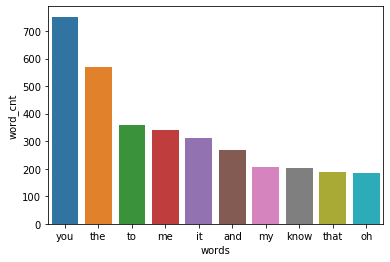

In [67]:
rock = populate_chart_with_lyrics(rock)
print_word_freq(rock)

you     763
the     456
me      376
it      324
to      307
and     268
my      248
that    203
don     193
all     181
dtype: int64

you     0.048494
the     0.028982
me      0.023897
it      0.020592
to      0.019512
and     0.017033
my      0.015762
that    0.012902
don     0.012266
all     0.011504
dtype: float64

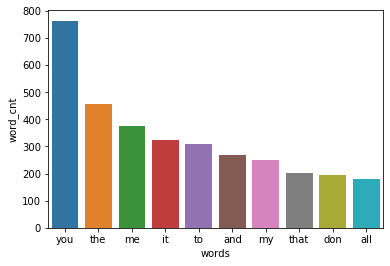

In [68]:
pop = populate_chart_with_lyrics(pop)
print_word_freq(pop)

the    547
you    528
and    348
to     274
on     216
we     212
in     199
it     199
my     181
of     174
dtype: int64

the    0.038050
you    0.036728
and    0.024207
to     0.019060
on     0.015025
we     0.014747
in     0.013843
it     0.013843
my     0.012590
of     0.012104
dtype: float64

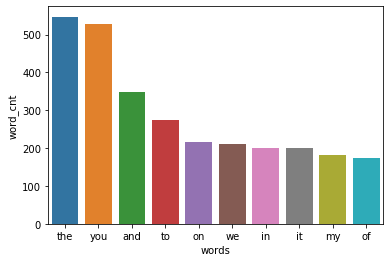

In [69]:
country = populate_chart_with_lyrics(country)
print_word_freq(country)

In [70]:
def find_most_freq_key_words(chart): #This removes unimportant words such as a, an, to, the, etc... 
    words = ['a', 'an', 'the','that','you','of', 'it', 'my', 'yeah', 'all', 'that', 'to', 'on', 'and', 'oh', 'be', 'in', 'when', 're', 'but', 'can', 'for', 'so']
    counts = get_chart_word_count(chart)
    counts = counts[~counts.index.isin(words)]
    return counts.nlargest(10) 

In [71]:
def print_word_key_freq(chart):
    freq = find_most_freq_key_words(chart)
    
    display(freq)
    display(freq / get_lyric_len(chart).sum(axis = 0, skipna = True))
    
    freq = pd.DataFrame({'words':freq.index, 'word_cnt':freq.values})
    sns.barplot(x="words", y="word_cnt", data=freq)
    

me      339
know    201
don     154
up      125
we      124
ll      116
like    112
what    106
your    102
down     99
dtype: int64

me      0.022197
know    0.013161
don     0.010084
up      0.008185
we      0.008119
ll      0.007596
like    0.007334
what    0.006941
your    0.006679
down    0.006482
dtype: float64

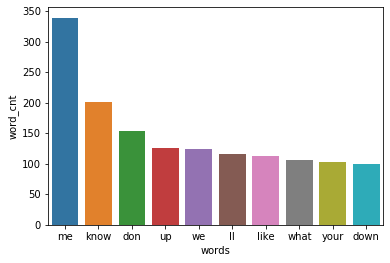

In [72]:
print_word_key_freq(rock)

me      376
don     193
we      167
love    132
your    130
do      118
know    107
ft      106
got     105
up       97
dtype: int64

me      0.023897
don     0.012266
we      0.010614
love    0.008389
your    0.008262
do      0.007500
know    0.006801
ft      0.006737
got     0.006673
up      0.006165
dtype: float64

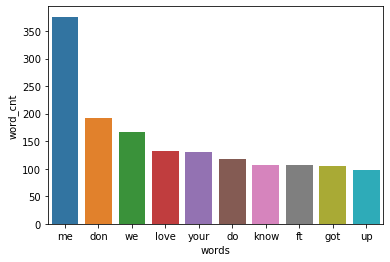

In [73]:
print_word_key_freq(pop)

we      212
me      168
got     155
your    145
what    131
don     116
she     114
one     112
just     98
ooh      98
dtype: int64

we      0.014747
me      0.011686
got     0.010782
your    0.010086
what    0.009112
don     0.008069
she     0.007930
one     0.007791
just    0.006817
ooh     0.006817
dtype: float64

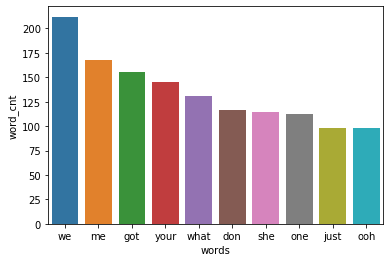

In [74]:
print_word_key_freq(country)

me      868
we      373
don     333
with    307
like    286
up      286
no      279
your    279
got     257
back    228
dtype: int64

me      0.022630
we      0.009725
don     0.008682
with    0.008004
like    0.007456
up      0.007456
no      0.007274
your    0.007274
got     0.006700
back    0.005944
dtype: float64

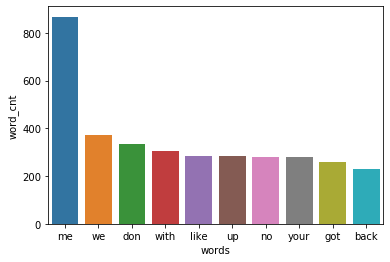

In [75]:
print_word_key_freq(top100)

In [76]:
#Are songs becoming more profane over time?
#We test this by looking into the percentage of lyrics that are profanities

!pip install profanity-check

from profanity_check import predict, predict_prob

In [120]:
def get_profan_freq(chart):
    freq = get_chart_word_count(chart)
    profan = {}
    percent = {}
    
    for row in freq.index:
        if predict([row]):
            profan[row] = freq[row]
            percent[row] = profan[row] / get_lyric_len(chart).sum(axis = 0, skipna = True)
               
    return percent

0.01632078423193242

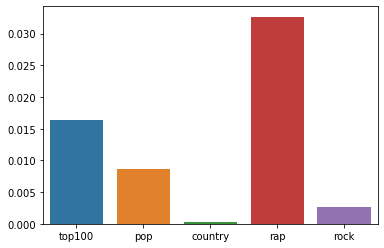

In [121]:
x = np.array(["top100", "pop", "country", "rap", "rock"])
y = []
y.append(sum(get_profan_freq(top100).values()))
y.append(sum(get_profan_freq(pop).values()))
y.append(sum(get_profan_freq(country).values()))
y.append(sum(get_profan_freq(rap).values()))
y.append(sum(get_profan_freq(rock).values()))
y = np.array(y)
sns.barplot(x=x, y=y)
sum(get_profan_freq(top100).values())

This graph shows the total percentage of lyrics in each chart that are classified as profane. As one would expect the rap chart has a much higher percentage of profane words then any other chart and top100 is the next highest because it has rap songs on it. Country has an extremely low percentage of profane words and rock also has a low percentage of profane words.

In [80]:
def profan_cnt_graph(chart):
    doc = create_term_doc_matrix(chart)
    cols = doc.columns

    for i in cols:
        if not predict([i]):
            cols = cols.drop([i])

    doc = doc[cols]
    sum = doc.sum(axis = 1, skipna = True) 
    sum = pd.DataFrame({'Title':sum.index, 'profan_cnt':sum.values})

    sum['Rank'] = chart['Rank']
    sns.regplot(x="Rank", y="profan_cnt", data=sum)

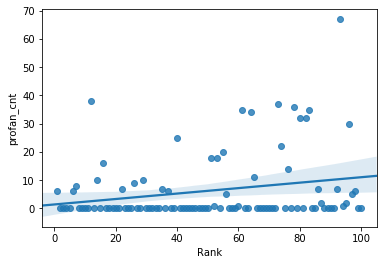

In [81]:
#Trend seems to be that higher ranking songs tend to have less profanity.
#This makes sense, less profanity makes the song easier to play in more places. 
profan_cnt_graph(top100)

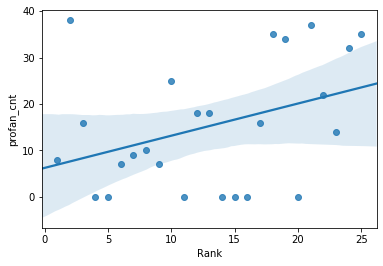

In [83]:
rap = populate_chart_with_lyrics(rap)
profan_cnt_graph(rap)

In [84]:
#Matching songs based off of lyrics
#A person enters n lyrics and we try to match which song in top100 is the best match
def find_best_match(words):
    print(tfidf[tfidf.index.isin(words)].sum(axis = 0, skipna = True).nlargest(1))

num = int(input("How many key words do you want to enter? "))
words = []

for i in range(num - 1):
    words.append(input("Please enter a key word: "))
words.append(input("Please enter your final key word: "))  

find_best_match(words)

How many key words do you want to enter? 0
Please enter your final key word: people
Title
Beautiful People    0.121843
dtype: float64


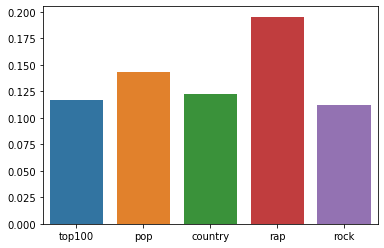

In [100]:
x = np.array(["top100", "pop", "country", "rap", "rock"])
y = []
y.append(average_cosine_similarity(create_tfidf(top100)))
y.append(average_cosine_similarity(create_tfidf(pop)))
y.append(average_cosine_similarity(create_tfidf(country)))
y.append(average_cosine_similarity(create_tfidf(rap)))
y.append(average_cosine_similarity(create_tfidf(rock)))
y = np.array(y)
sns.barplot(x=x, y=y)

This chart shows the average pairwise cosine similarity over the five different charts we are looking at. This means that the cosine similarity was calculated bewteen every pair of songs in each chart and then the average was taken for all of those values. It is interesting to see that rap has the most similarity between all of the songs in its top chart and then  the second highest similarity is pop. The top100, rock and country all have similar average simalirty scores. The fact that all of these scors are relatively low as the largest one is less than .2 means that songs in the same genre or on the top100 chart are often very different in their lyrics.

top100's most similar pair of songs is Into The Unknown and Into The Unknown
pop's most similar pair of songs is Panini and Take What You Want
country's most similar pair of songs is I Hope and I Hope You're Happy Now
rap's most similar pair of songs is Death and 223's
rock's most similar pair of songs is Under The Graveyard and Legendary


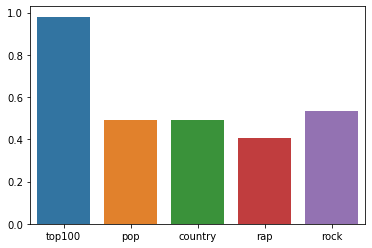

In [104]:
x = np.array(["top100", "pop", "country", "rap", "rock"])
y = []
z = {}
score,names = top_pairwise_cosine_similarity(create_tfidf(top100))
y.append(score)
z["top100"] = names
score,names = top_pairwise_cosine_similarity(create_tfidf(pop))
y.append(score)
z["pop"] = names
score,names = top_pairwise_cosine_similarity(create_tfidf(country))
y.append(score)
z["country"] = names
score,names = top_pairwise_cosine_similarity(create_tfidf(rap))
y.append(score)
z["rap"] = names
score,names = top_pairwise_cosine_similarity(create_tfidf(rock))
y.append(score)
z["rock"] = names
y = np.array(y)
sns.barplot(x=x, y=y)
for chart in z:
    print(chart + "'s most similar pair of songs is " + z[chart][0] + " and " + z[chart][1])

The graph shows that the top100 has the most similar pair of songs by far than any other chart. This is due to the fact that two different versions of the same song are both on the Billboard top100 chart, so this is a bit of an outlier and does not normally occur. It is interesting to see that rap has the lowest max similarity between any pair of songs as it was the chart that had the highest average pairwise similarity out of all of the charts. Also, the fact that the max similarity value is usually around .5 shows that there is significant overlap between certain songs in the same genre.